In [3]:
import os
import zipfile
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

# Configure parallelism parameters
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(8)

# Extract the zip files for training and testing data.
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train_dataset')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test_dataset')


In [4]:
# Running the function 5 times and calculating the average
total_time = 0
for i in range(5):
    def sharpen_image(image):
        # Apply Gaussian blur
        blurred = tf.image.adjust_contrast(image, contrast_factor=3)
    # Perform edge enhancement
        sharp_image = tf.clip_by_value(image * 2 - blurred, 0.0, 1.0)
        return sharp_image

    start_time_preprocessing_dataset = time.time() * 1000 #this time include two preprocessing functions: load_and_preprocess_image and sharpen_image

    train_data_gen = ImageDataGenerator( preprocessing_function=sharpen_image )
    test_data_gen = ImageDataGenerator( preprocessing_function=sharpen_image)

    train_data_gen = ImageDataGenerator(rescale=1./255)
    test_data_gen = ImageDataGenerator(rescale=1./255)

    train_generator = train_data_gen.flow_from_directory(
        'train_dataset/train',
        target_size=(48, 48),
        batch_size=32,
        color_mode="grayscale",
        class_mode='categorical'
    )

    test_generator = test_data_gen.flow_from_directory(
        'test_dataset/test',
        target_size=(48, 48),
        batch_size=32,
        color_mode="grayscale",
        class_mode='categorical'
    )

    end_time_preprocessing_dataset = time.time() * 1000
    data_processing_time = end_time_preprocessing_dataset - start_time_preprocessing_dataset
    total_time += data_processing_time

average_time = total_time / 5
print("\nAverage Data Preprocessing Time: {:.5f} milliseconds".format(average_time))


Found 23894 images belonging to 5 classes.
Found 5989 images belonging to 5 classes.
Found 23894 images belonging to 5 classes.
Found 5989 images belonging to 5 classes.
Found 23894 images belonging to 5 classes.
Found 5989 images belonging to 5 classes.
Found 23894 images belonging to 5 classes.
Found 5989 images belonging to 5 classes.
Found 23894 images belonging to 5 classes.
Found 5989 images belonging to 5 classes.

Average Data Preprocessing Time: 1594.89570 milliseconds


In [5]:

# Parameters
batch_size = 32
# Model Creation
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = Adam(learning_rate=lr_schedule)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  
])      

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)      


# Create a TensorBoard callback for logging
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)

# Configure EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric.
)

# Train the model
start_time_training = time.time() * 1000
emotion_model_info = model.fit(
    train_generator,  # Use the train_dataset instead of train_generator
    epochs=30,
    steps_per_epoch=len(train_generator),  # Adjust step size according to train_dataset
    validation_data=test_generator,  # Use the validation_dataset instead of test_generator
    validation_steps=len(test_generator),  # Adjust step size according to validation_dataset
    callbacks=[tensorboard_callback, early_stopping_callback]
)

end_time_training = time.time() * 1000
training_time = end_time_training - start_time_training
print("Training Time: {:.5f} milliseconds".format(training_time))


Epoch 1/30
747/747 [==============================] - 156s 207ms/step - loss: 1.5116 - accuracy: 0.3358 - val_loss: 1.3442 - val_accuracy: 0.4528
Epoch 2/30
747/747 [==============================] - 171s 229ms/step - loss: 1.3034 - accuracy: 0.4700 - val_loss: 1.2272 - val_accuracy: 0.5073
Epoch 3/30
747/747 [==============================] - 153s 205ms/step - loss: 1.2081 - accuracy: 0.5162 - val_loss: 1.1594 - val_accuracy: 0.5261
Epoch 4/30
747/747 [==============================] - 173s 231ms/step - loss: 1.1301 - accuracy: 0.5495 - val_loss: 1.0737 - val_accuracy: 0.5687
Epoch 5/30
747/747 [==============================] - 170s 228ms/step - loss: 1.0689 - accuracy: 0.5760 - val_loss: 1.0156 - val_accuracy: 0.5998
Epoch 6/30
747/747 [==============================] - 157s 210ms/step - loss: 1.0122 - accuracy: 0.6001 - val_loss: 0.9910 - val_accuracy: 0.6106
Epoch 7/30
747/747 [==============================] - 171s 228ms/step - loss: 0.9679 - accuracy: 0.6223 - val_loss: 0.9496 -

In [6]:
# save model structure in jason file
model_json = model.to_json()
with open("parallel_emotion_model.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
model.save_weights('parallel_emotion_model.h5')

In [7]:
import numpy as np
from keras.models import model_from_json
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay,accuracy_score

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad", 4: "Surprised"}
# load json and create model
json_file = open('parallel_emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)
# load weights into new model
emotion_model.load_weights("parallel_emotion_model.h5")
print("Loaded model from disk")
predictions = emotion_model.predict(test_generator)

Loaded model from disk
188/188 [==============================] - 6s 32ms/step


-----------------------------------------------------------------
[[138 304 196 188 132]
 [300 518 370 304 259]
 [157 390 262 244 173]
 [181 398 243 227 178]
 [137 244 175 151 120]]
-----------------------------------------------------------------


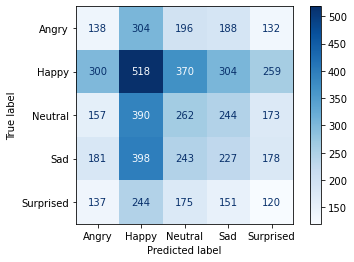

In [12]:
emotion_label = ["Angry","Happy","Neutral","Sad","Surprised"]
print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(test_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
print("-----------------------------------------------------------------")
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_label)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [13]:
# Classification report
emotion_dict = {0: "Angry", 1: "Happy", 2: "Neutral", 3: "Sad", 4: "Surprised"}
print("-----------------------------------------------------------------")
print(classification_report(test_generator.classes, predictions.argmax(axis=1)))


-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.15      0.14      0.15       958
           1       0.28      0.30      0.29      1751
           2       0.21      0.21      0.21      1226
           3       0.20      0.19      0.19      1227
           4       0.14      0.15      0.14       827

    accuracy                           0.21      5989
   macro avg       0.20      0.20      0.20      5989
weighted avg       0.21      0.21      0.21      5989



In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

In [15]:
print(model.input_shape)

(None, 48, 48, 1)


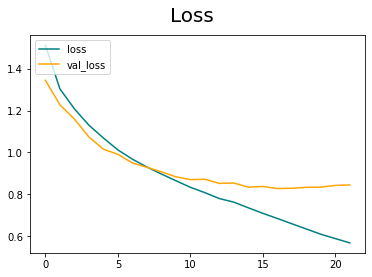

In [16]:
import matplotlib.pyplot as plt

#Loss data 
fig = plt.figure()
plt.plot(emotion_model_info.history['loss'], color='teal', label='loss')
plt.plot(emotion_model_info.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

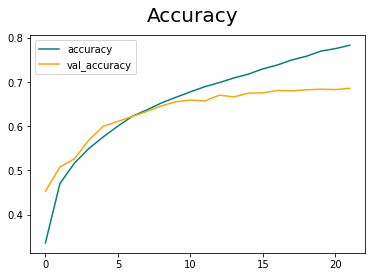

In [17]:
#accuracy
fig = plt.figure()
plt.plot(emotion_model_info.history['accuracy'], color='teal', label='accuracy')
plt.plot(emotion_model_info.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()